In [1]:
import numpy as np # 数组常用库
import pandas as pd # 读入csv常用库
from patsy import dmatrices # 可根据离散变量自动生成哑变量
from sklearn.linear_model import LogisticRegression # sk-learn库Logistic Regression模型
from sklearn.model_selection import train_test_split, cross_val_score # sk-learn库训练与测试
from sklearn import metrics # 生成各项测试指标库
import matplotlib.pyplot as plt # 画图常用库

从../input/HR_comma_sep.csv文件中读入数据

In [2]:
data = pd.read_csv("./HR_comma_sep.csv")
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [3]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

观察离职人数与工资分布的关系

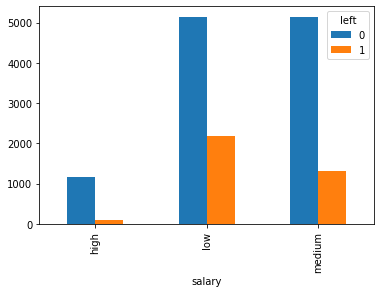

In [4]:
pd.crosstab(data.salary, data.left).plot(kind='bar')
plt.show()

观察离职比例与工资分布的关系

left       0     1
salary            
high    1155    82
low     5144  2172
medium  5129  1317
salary
high      1237
low       7316
medium    6446
dtype: int64


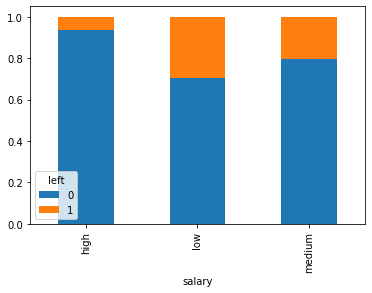

In [5]:
q = pd.crosstab(data.salary, data.left)
print(q)
print(q.sum(1))
q.div(q.sum(1), axis = 0).plot(kind='bar', stacked = True)
plt.show()

观察员工满意度的分布图(histogram)

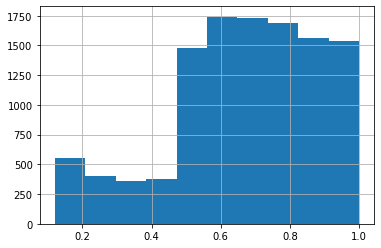

In [6]:
data[data.left==0].satisfaction_level.hist()
plt.show()

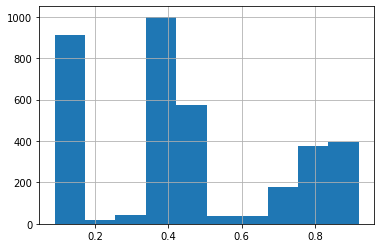

In [7]:
data[data.left==1].satisfaction_level.hist()
plt.show()

dmatrices将数据中的离散变量变成哑变量，并指明用satisfaction_level, last_evaluation, ... 来预测left
然后重命名列的名字

In [8]:
model = LogisticRegression()
y, X = dmatrices('left~satisfaction_level+last_evaluation+number_project+average_montly_hours+time_spend_company+Work_accident+promotion_last_5years+C(sales)+C(salary)', data, return_type='dataframe')
X = X.rename(columns = {
    'C(sales)[T.RandD]': 'Department: Random',
    'C(sales)[T.accounting]': 'Department: Accounting',
    'C(sales)[T.hr]': 'Department: HR',
    'C(sales)[T.management]': 'Department: Management',
    'C(sales)[T.marketing]': 'Department: Marketing',
    'C(sales)[T.product_mng]': 'Department: Product_Management',
    'C(sales)[T.sales]': 'Department: Sales',
    'C(sales)[T.support]': 'Department: Support',
    'C(sales)[T.technical]': 'Department: Technical',
    'C(salary)[T.low]': 'Salary: Low',
    'C(salary)[T.medium]': 'Salary: Medium'}) 
y = np.ravel(y) # 将y变成np的一维数组

用X和y训练模型，然后输出X中每一项自变量对于y的影响
zip(a,b)可将a的每一个元素和b里对应位置的元素组成一对

In [9]:
model.fit(X, y)
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,1
0,Intercept,[-0.7241218101303709]
1,Department: Random,[-0.4646533540507806]
2,Department: Accounting,[0.11480746995707178]
3,Department: HR,[0.34470249740075476]
4,Department: Management,[-0.36197691576765323]
5,Department: Marketing,[0.0942542721870518]
6,Department: Product_Management,[-0.03808031714105212]
7,Department: Sales,[0.06953539021768723]
8,Department: Support,[0.15060969294430204]
9,Department: Technical,[0.1736770340382351]


model.score为准确率(0到1之间)

In [10]:
print(model.score(X,y))

0.7919194612974199


In [11]:
#一个高工资HR，对公司满意度0.5, 上次评审0.7分，做过4个项目，每月平均工作160小时，在公司呆了3年，过去5年没有被晋升，没有工伤
model.predict_proba([[1,0,0,1,0,0,0,0,0,0,0,0, 0.5, 0.7, 4.0, 160, 3.0, 0, 0]])

array([[0.9157868, 0.0842132]])

In [12]:
pred = model.predict(X)
(abs(pred-y)).sum() / len(y)

0.20808053870258017

生成7:3的训练测试集

In [13]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(Xtrain, ytrain)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
model2 = LogisticRegression(C=10000)
model2.fit(Xtrain, ytrain)
pred = model2.predict(Xtest)
metrics.accuracy_score(ytest, pred)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7917777777777778

观察实际离职/未离职被预测成为离职/未离职的数目

In [15]:
metrics.confusion_matrix(ytest, pred)
#        prediction
#
#
#actual
#
#
#

array([[3199,  263],
       [ 674,  364]])

classification_report会输出每一类对应的precision, recall

In [16]:
#sklearn.metrics.classification_report(y_true, y_pred)
print(metrics.classification_report(ytest, pred))


              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      3462
         1.0       0.58      0.35      0.44      1038

    accuracy                           0.79      4500
   macro avg       0.70      0.64      0.65      4500
weighted avg       0.77      0.79      0.77      4500



10份的交叉验证Cross Validation

In [17]:
print(cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[0.80679547 0.792      0.79533333 0.78733333 0.804      0.804
 0.794      0.79       0.74449633 0.73582388]


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
